In [1]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports
import GEMS_TCO
from GEMS_TCO import kernels

from GEMS_TCO import kernels 
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import load_data
from GEMS_TCO import alg_optimization, alg_opt_Encoder
from GEMS_TCO import configuration as config

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder

from GEMS_TCO import configuration as config
from GEMS_TCO import data_preprocess as dmbh

import os
from sklearn.neighbors import BallTree

# Load data

In [4]:
lon_s = 123
lon_e = 133
step_lat = 0.044
step_lon = 0.063

lat_coords = np.arange( 5 -0.044- 0.0002, 0 -0.044, -0.044)
lon_coords = np.arange( lon_e-step_lon- 0.0002, lon_s-step_lon, -step_lon)

# Apply the shift as in the original code
# These are the unique lat/lon values for the "center_points" grid
final_lat_values = lat_coords + step_lat 
final_lon_values = lon_coords + step_lon 

# Create 2D grid with broadcasting
#decrement = 0.00012
decrement = 0 
lat_grid = final_lat_values[:, None] + np.arange(len(final_lon_values)) * decrement  # shape: (228, 152)


mac_data_path = config.mac_data_load_path
years = [2024]  # years = [2023,2024]
months = list( range(7,8))
year = years[0]
month = months[0]
month_str = f"{month:02d}"  
filename = f"pickle_2024/orbit_map{str(year)[2:]}_{month_str}.pkl"
picklefile_path = Path(mac_data_path) / filename
print(picklefile_path)

with open(picklefile_path, 'rb') as pickle_file:
    data_map_hour = pickle.load(pickle_file)

# Base file path and settings
# base_path = "C:\\Users\\joonw\\TCO\\GEMS_data"    MSI notebook

mac_data_path = config.mac_data_load_path
lat_start, lat_end, lon_start, lon_end = 0, 5, 123, 133
step_lat, step_lon = 0.044, 0.063

# df = pd.read_csv("C:\\Users\\joonw\\TCO\\GEMS_data\\data_2024\\data_24_07_0131_N510_E110120.csv")  MSI notebook
df = pd.read_csv("/Users/joonwonlee/Documents/GEMS_DATA/data_2024/data_24_07_0131_N05_E123133.csv")  # MAC

/Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/orbit_map24_07.pkl


In [ ]:
''' 
instance = dmbh.center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)

for year in years:        # years = [2023,2024]
    for month in months:  
        try:
            # load pickle (dense ORI data)
            pickle_path = os.path.join(mac_data_path, f'pickle_{year}')
            input_filename = f"orbit_map{str(year)[2:]}_{month_str}.pkl"
            input_filepath = os.path.join(pickle_path, input_filename)
            with open(input_filepath, 'rb') as pickle_file:
                loaded_map = pickle.load(pickle_file)
            center_points = instance.make_center_points_wo_calibration(step_lat = step_lat, step_lon= step_lon)
            coarse_cen_map = instance.coarse_by_center(loaded_map, center_points)

            # Save pickle (coarse data)
            output_filename = f"coarse_cen_map_without_decrement_latitude{str(year)[2:]}_{month_str}.pkl"
            output_filepath = os.path.join(pickle_path, output_filename)
            with open(output_filepath, 'wb') as pickle_file:
                pickle.dump(coarse_cen_map, pickle_file)
            
            print(f"Successfully processed and saved data for year {str(year)[2:]} month {month_str}.")
        except FileNotFoundError:
            print(f"Warning: File {input_filename} not found. Skipping.")
        except Exception as e:
            print(f"Error processing file {input_filename}: {e}")
'''

In [5]:
pickle_path = os.path.join(mac_data_path, f'pickle_{year}')
output_filename = f"coarse_cen_map_without_decrement_latitude{str(year)[2:]}_{month_str}.pkl"
output_filepath = os.path.join(pickle_path, output_filename)

with open(output_filepath, 'rb') as pickle_file:
    cbmap_ori = pickle.load(pickle_file)


load_data_instance = GEMS_TCO.load_data('')

df_day_list = []
df_day_map_list = []
for i in range(31):
    cur_map, cur_df =load_data_instance.load_working_data_byday_wo_mm(cbmap_ori,[i*8, (i+1)*8])
    df_day_list.append( cur_df )
    df_day_map_list.append( cur_map )

# Apply laplacian filter

In [6]:
import torch
import numpy as np
import torch.nn.functional as F

def subset_tensor(df_tensor: torch.Tensor) -> torch.Tensor:
    """
    Subsets a tensor to a specific lat/lon range.
    Columns are assumed to be [lat, lon, ozone, time].
    """
    lat_mask = (df_tensor[:, 0] >= 0) & (df_tensor[:, 0] <= 2.9)
    lon_mask = (df_tensor[:, 1] >= 123.5) & (df_tensor[:, 1] <= 131.7)
    
    # We apply the mask to the full tensor
    df_sub = df_tensor[lat_mask & lon_mask].clone()
    return df_sub

def apply_laplacian_2d_valid_tensor(df_tensor: torch.Tensor) -> torch.Tensor:
    """
    Applies a 2D discrete Laplacian filter using 'mode=valid' on a PyTorch tensor.
    The input tensor columns are assumed to be [lat, lon, ozone, time].
    """
    # Extract unique coordinates and data
    unique_lats = torch.unique(df_tensor[:, 0])
    unique_lons = torch.unique(df_tensor[:, 1])
    
    lat_count = unique_lats.size(0)
    lon_count = unique_lons.size(0)
    
    if df_tensor.size(0) != lat_count * lon_count:
        raise ValueError("Tensor size does not match the grid dimensions (lat * lon).")

    ozone_data = df_tensor[:, 2].reshape(lat_count, lon_count)

    # Define the 3x3 discrete Laplacian kernel as a PyTorch tensor
    laplacian_kernel = torch.tensor([[0, 1, 0],
                                     [1, -4, 1],
                                     [0, 1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Reshape ozone data for conv2d: (batch_size, channels, height, width)
    ozone_data_reshaped = ozone_data.unsqueeze(0).unsqueeze(0)

    # Apply convolution
    laplacian_grid_cropped = F.conv2d(ozone_data_reshaped, laplacian_kernel, padding='valid')
    laplacian_values = laplacian_grid_cropped.squeeze().flatten()

    # Determine the new, cropped coordinates
    cropped_lats = unique_lats[1:-1]
    cropped_lons = unique_lons[1:-1]
    
    if len(cropped_lats) == 0 or len(cropped_lons) == 0:
        return torch.empty(0, 4)

    # Create a new meshgrid for the cropped coordinates
    new_lon_grid, new_lat_grid = torch.meshgrid(cropped_lons, cropped_lats, indexing='xy')
    
    # Preserve time from the original tensor
    time_value = df_tensor[0, 3].repeat(laplacian_values.size(0))

    # Create the new tensor
    new_tensor = torch.stack([new_lat_grid.flatten(), new_lon_grid.flatten(), laplacian_values, time_value], dim=1)
    
    return new_tensor

processed_tensor_map = []
processed_df = []

for day_map in df_day_map_list:
    
    tensors_to_aggregate = []
    
    for key, tensor in day_map.items():
        # Step 1: Subset the tensor.
        subsetted = subset_tensor(tensor)
        
        if subsetted.size(0) > 0:
            laplacian_applied = apply_laplacian_2d_valid_tensor(subsetted)
            if laplacian_applied.size(0) > 0:
                tensors_to_aggregate.append(laplacian_applied)

    # Step 3: Concatenate all the processed tensors from the 8-hour period.
    if tensors_to_aggregate:
        aggregated_day_tensor = torch.cat(tensors_to_aggregate, dim=0)
        processed_df.append(aggregated_day_tensor)
        
    # The 'processed_tensors' list remains the same, storing the dictionary for each day.
    processed_tensor_map.append(day_map)

# Now, processed_df2 will contain a single aggregated tensor for each day (8-hour period).
# You can inspect the results:
print("Number of aggregated day tensors:", len(processed_df))
if processed_df:
    print("Shape of the first aggregated tensor:", processed_df[0].shape)
    print("First aggregated tensor head:")
    print(processed_df[0][:5])


Number of aggregated day tensors: 31
Shape of the first aggregated tensor: torch.Size([65536, 4])
First aggregated tensor head:
tensor([[ 7.2000e-02,  1.2361e+02, -6.5655e+00,  2.1000e+01],
        [ 7.2000e-02,  1.2368e+02, -3.0364e+00,  2.1000e+01],
        [ 7.2000e-02,  1.2374e+02,  2.0616e+01,  2.1000e+01],
        [ 7.2000e-02,  1.2380e+02, -4.3127e+00,  2.1000e+01],
        [ 7.2000e-02,  1.2386e+02, -1.0213e+00,  2.1000e+01]])


# periodogram

In [7]:
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

def plot_2d_periodogram_contour(data_2d: np.ndarray):
    """
    Computes the 2D Periodogram (Power Spectral Density) of the input data
    and plots it using contour lines in the frequency domain.

    The plot axes represent the normalized spatial frequencies (wavenumbers),
    with the DC component (zero frequency) centered at (0, 0).

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N
    
    if M != 64 or N != 128:
        print(f"Warning: Expected input shape (64, 128), received {data_2d.shape}. Plotting may be incorrect.")
        # Attempt to proceed only if the total size is correct, otherwise raise
        if N_TOTAL != 8192:
             raise ValueError(f"Input array must contain 8192 elements. Received {N_TOTAL}.")


    # --- 1. Compute 2D FFT and PSD ---
    
    # Compute the 2D Discrete Fourier Transform (DFT)
    fft_coeff = fftn(data_2d)
    
    # Calculate the Power Spectral Density (Periodogram): |FFT|^2 / N
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL

    # Shift the zero frequency (DC component) to the center of the array
    psd_shifted = fftshift(psd_2d)

    # --- 2. Generate Frequency Axes ---
    
    # fftfreq generates normalized frequencies, ranging from -0.5 to 0.5 cycles/sample
    # We use fftshift to put the zero frequency in the center, matching the PSD shift.
    
    # Frequencies for the Latitude dimension (M=64)
    freq_lat = fftshift(fftfreq(M))
    
    # Frequencies for the Longitude dimension (N=128)
    freq_lon = fftshift(fftfreq(N))

    # Create 2D meshgrid for plotting (Lon Freq, Lat Freq)
    # Note: meshgrid orders X (columns/Lon) first, then Y (rows/Lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Contour) ---

    # Define custom blue colors
    blue_colors = [
        (222/255, 235/255, 247/255), # Lightest blue/white -> Low Power
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    # Darkest blue -> High Power (Strong Spectrum)
    ]
    # Create the custom colormap using the LinearSegmentedColormap class
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Use log scale for the contour levels since PSD usually spans many orders of magnitude
    log_psd = np.log10(psd_shifted + np.finfo(float).eps) # Add epsilon to avoid log(0)
    
    # Create 15 logarithmically spaced contour levels
    levels = np.linspace(log_psd.min(), log_psd.max(), 15)
    
    # Use pcolormesh for continuous color mapping of the PSD (using the custom blue map)
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    
    # Overlay contour lines for clarity
    # Note: The white contour lines were removed to enhance color intuition
    
    plt.colorbar(label='Log₁₀(Power Spectral Density)')
    
    # Set labels based on the standard convention (Long Freq on X, Lat Freq on Y)
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    plt.title(f'2D Spatial Periodogram Contour (Grid: {M}x{N})')
    
    # Ensure axes are square or equal if desired (optional)
    # plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- Example Usage (Using Actual 64x128 Ozone Data) ---

M, N = 64, 128
# Assuming processed_df is defined and available globally.

# NOTE: The previous error indicates that d1h1 contains 4 columns, leading to a size 32768.
# We must ensure only the ozone column is reshaped.
try:
    day = 2
    # 1. Select the unique time steps from the data
    unique_times = processed_df[day-1][:, 3].unique()
    # 2. Filter the data to get the first spatial slice (first hour data)
    d1h1_slice = processed_df[day-1][processed_df[day-1][:, 3] == unique_times[0]]

    # CRUCIAL: Select only the ozone column (index 2) and reshape into the M x N grid.
    ozone_signal_2d = d1h1_slice[:, 2].numpy().reshape(M, N)

    # Run the function
    plot_2d_periodogram_contour(ozone_signal_2d)

except NameError:
    print("\nError: The required 'processed_df' tensor is not defined.")
    print("Cannot run the plotting example without input data.")
except IndexError:
    print("\nError: Data filtering failed. Check if processed_df[0] has time index in column 3.")


Error: The required 'processed_df' tensor is not defined.
Cannot run the plotting example without input data.


# cross periodogram (2d laplacian filtered data)

Averaging cross-periodogram for hour 3 and 4 across 4 days on Laplacian-filtered data...
  - Successfully processed Day 0.
  - Successfully processed Day 1.
  - Successfully processed Day 2.
  - Successfully processed Day 3.


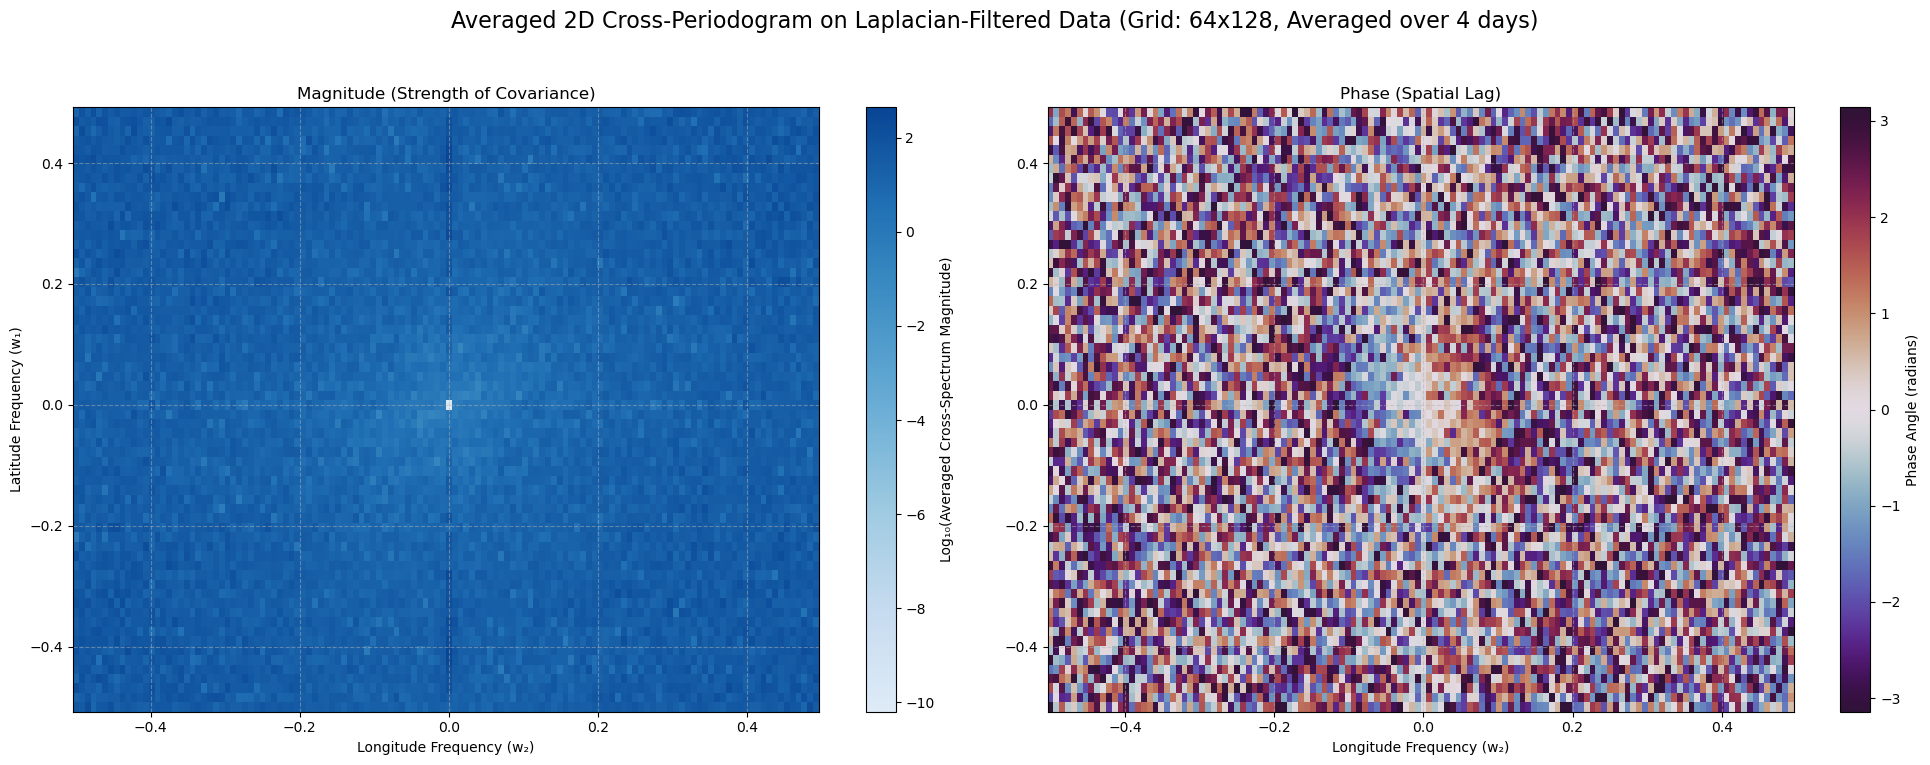

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

# This function is unchanged.
def calculate_cross_spectrum(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Helper function to compute the 2D cross-spectrum for a single pair of datasets.
    Returns the complex-valued, shifted cross-spectrum.
    """
    if data1_2d.shape != data2_2d.shape:
        raise ValueError("Input data arrays must have the same dimensions.")
    
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # Demean, FFT, and compute the cross-spectrum
    # Note: Demeaning is still good practice even on filtered data.
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)
    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)
    # The cross-spectrum convention used here is F1 * conj(F2)
    cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
    
    return fftshift(cross_spectrum)

# This function is also unchanged.
def plot_averaged_cross_periodogram(avg_cross_spec: np.ndarray, M: int, N: int, num_days: int):
    """
    Plots the magnitude and phase of a pre-averaged 2D cross-periodogram.
    """
    # --- 1. Separate Averaged Magnitude and Phase ---
    magnitude = np.abs(avg_cross_spec)
    phase = np.angle(avg_cross_spec)

    # --- 2. Generate Frequency Axes ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Two Subplots) ---
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title = f'Averaged 2D Cross-Periodogram on Laplacian-Filtered Data (Grid: {M}x{N}, Averaged over {num_days} days)'
    fig.suptitle(title, fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_magnitude = np.log10(magnitude + np.finfo(float).eps)
    im1 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, log_magnitude, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Averaged Cross-Spectrum Magnitude)')
    ax.set_title('Magnitude (Strength of Covariance)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.grid(True, linestyle='--', alpha=0.5)

    # -- Plot 2: Phase --
    ax = axes[1]
    # 'twilight_shifted' is an excellent colormap for phase data as it is cyclic
    im2 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, phase, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase (Spatial Lag)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## --- Main Script Logic (Adapted for processed_df) ---
# This part loops through the days, calculates, and averages the results.

# Define grid dimensions and processing parameters
M, N = 64, 128
# Assuming processed_df is a list where each element is a tensor for a day's data
# Example: processed_df[0] is day 1, processed_df[1] is day 2, etc.
days_to_average = np.arange(0, 4) # Use the first nine days (Day 1 to Day 9)
keyhour = 3 # This will correspond to the 4th hour (index 3)
cross_spectra_list = []

print(f"Averaging cross-periodogram for hour {keyhour} and {keyhour+1} across {len(days_to_average)} days on Laplacian-filtered data...")

# Loop through the specified day numbers
for day_num in days_to_average:
    day_idx = day_num - 1 # Convert to 0-based index for the list
    try:
        # Get all data for the current day
        daily_data = processed_df[day_idx]
        
        # Get the unique, sorted time steps for this day
        unique_times = np.unique(daily_data[:, 3].numpy())
        
        # --- Load data for the first hour ---
        time1 = unique_times[keyhour]
        slice1 = daily_data[daily_data[:, 3] == time1]
        ozone_signal_1 = slice1[:, 2].numpy().reshape(M, N)

        # --- Load data for the consecutive hour ---
        time2 = unique_times[keyhour + 1]
        slice2 = daily_data[daily_data[:, 3] == time2]
        ozone_signal_2 = slice2[:, 2].numpy().reshape(M, N)
        
        # Calculate the cross-spectrum for this day and add it to our list
        daily_cross_spec = calculate_cross_spectrum(ozone_signal_1, ozone_signal_2)
        cross_spectra_list.append(daily_cross_spec)
        print(f"  - Successfully processed Day {day_num}.")

    except IndexError:
        print(f"  - Could not process Day {day_num}. Reason: Not enough hours available in data for hour index {keyhour+1}.")
    except Exception as e:
        print(f"  - Could not process Day {day_num}. Reason: {e}")

# --- Averaging and Plotting ---
if cross_spectra_list:
    # Stack all the daily spectra into a 3D array and average along the 'day' axis
    avg_cross_spec = np.mean(np.array(cross_spectra_list), axis=0)
    
    # Plot the final averaged result
    plot_averaged_cross_periodogram(avg_cross_spec, M, N, len(cross_spectra_list))
else:
    print("\nNo data was successfully processed. Cannot generate plot.")

# original data

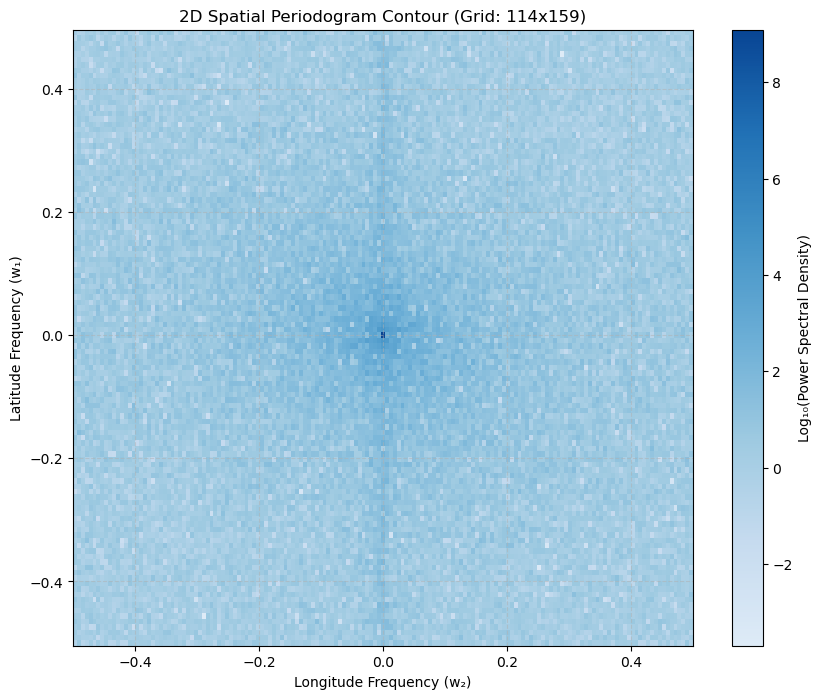

In [9]:
def plot_2d_periodogram_contour_ori(data_2d: np.ndarray):
    """
    Computes the 2D Periodogram (Power Spectral Density) of the input data
    and plots it using contour lines in the frequency domain.

    The plot axes represent the normalized spatial frequencies (wavenumbers),
    with the DC component (zero frequency) centered at (0, 0).

    Args:
        data_2d (np.ndarray): A 2D array of ozone values (assumed to be 64x128).
    """
    M, N = data_2d.shape
    N_TOTAL = M * N
    


    # --- 1. Compute 2D FFT and PSD ---
    
    # Compute the 2D Discrete Fourier Transform (DFT)
    fft_coeff = fftn(data_2d)
    
    # Calculate the Power Spectral Density (Periodogram): |FFT|^2 / N
    psd_2d = np.abs(fft_coeff)**2 / N_TOTAL

    # Shift the zero frequency (DC component) to the center of the array
    psd_shifted = fftshift(psd_2d)

    # --- 2. Generate Frequency Axes ---
    
    # fftfreq generates normalized frequencies, ranging from -0.5 to 0.5 cycles/sample
    # We use fftshift to put the zero frequency in the center, matching the PSD shift.
    
    # Frequencies for the Latitude dimension (M=64)
    freq_lat = fftshift(fftfreq(M))
    
    # Frequencies for the Longitude dimension (N=128)
    freq_lon = fftshift(fftfreq(N))

    # Create 2D meshgrid for plotting (Lon Freq, Lat Freq)
    # Note: meshgrid orders X (columns/Lon) first, then Y (rows/Lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Contour) ---

    # Define custom blue colors
    blue_colors = [
        (222/255, 235/255, 247/255), # Lightest blue/white -> Low Power
        (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255),
        (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255),
        (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)    # Darkest blue -> High Power (Strong Spectrum)
    ]
    # Create the custom colormap using the LinearSegmentedColormap class
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", blue_colors)
    
    plt.figure(figsize=(10, 8))
    
    # Use log scale for the contour levels since PSD usually spans many orders of magnitude
    log_psd = np.log10(psd_shifted + np.finfo(float).eps) # Add epsilon to avoid log(0)
    
    # Create 15 logarithmically spaced contour levels
    levels = np.linspace(log_psd.min(), log_psd.max(), 15)
    
    # Use pcolormesh for continuous color mapping of the PSD (using the custom blue map)
    plt.pcolormesh(freq_grid_lon, freq_grid_lat, log_psd, shading='auto', cmap=blue_cmap)
    
    # Overlay contour lines for clarity
    # Note: The white contour lines were removed to enhance color intuition
    
    plt.colorbar(label='Log₁₀(Power Spectral Density)')
    
    # Set labels based on the standard convention (Long Freq on X, Lat Freq on Y)
    plt.xlabel('Longitude Frequency (w₂)')
    plt.ylabel('Latitude Frequency (w₁)')
    plt.title(f'2D Spatial Periodogram Contour (Grid: {M}x{N})')
    
    # Ensure axes are square or equal if desired (optional)
    # plt.gca().set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

day = 2
keyhour = 4
keys = list(df_day_map_list[day].keys())
df1 = df_day_map_list[day][keys[keyhour]]

n_lat = len(df1[:,0].unique())
n_lon = len(df1[:,1].unique())
ozone_signal_2d = df1[:, 2].numpy().reshape(n_lat, n_lon)

plot_2d_periodogram_contour_ori(ozone_signal_2d)

Averaging cross-periodogram for hour 3 and 4 across 3 days...
  - Successfully processed Day 0.
  - Successfully processed Day 1.
  - Successfully processed Day 2.


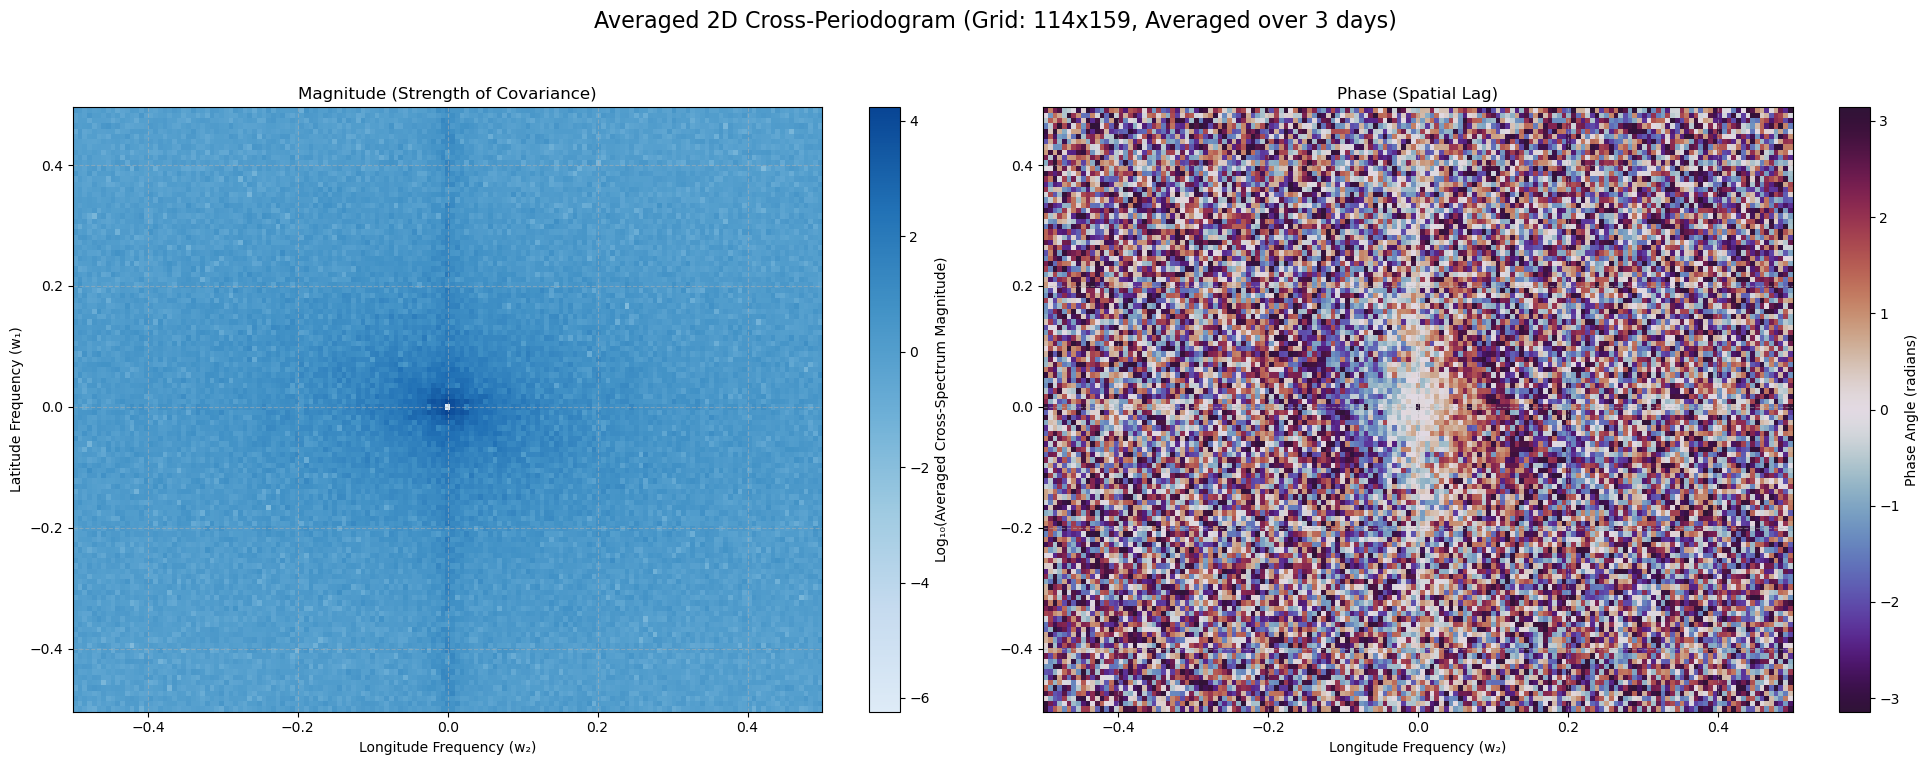

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftshift, fftfreq
from matplotlib.colors import LinearSegmentedColormap

def calculate_cross_spectrum(data1_2d: np.ndarray, data2_2d: np.ndarray):
    """
    Helper function to compute the 2D cross-spectrum for a single pair of datasets.
    Returns the complex-valued, shifted cross-spectrum.
    """
    if data1_2d.shape != data2_2d.shape:
        raise ValueError("Input data arrays must have the same dimensions.")
    
    M, N = data1_2d.shape
    N_TOTAL = M * N

    # Demean, FFT, and compute the cross-spectrum
    d1_demeaned = data1_2d - np.mean(data1_2d)
    d2_demeaned = data2_2d - np.mean(data2_2d)
    fft1 = fftn(d1_demeaned)
    fft2 = fftn(d2_demeaned)
    cross_spectrum = (fft1 * np.conj(fft2)) / N_TOTAL
    
    return fftshift(cross_spectrum)

def plot_averaged_cross_periodogram(avg_cross_spec: np.ndarray, M: int, N: int, num_days: int):
    """
    Plots the magnitude and phase of a pre-averaged 2D cross-periodogram.
    """
    # --- 1. Separate Averaged Magnitude and Phase ---
    magnitude = np.abs(avg_cross_spec)
    phase = np.angle(avg_cross_spec)

    # --- 2. Generate Frequency Axes ---
    freq_lat = fftshift(fftfreq(M))
    freq_lon = fftshift(fftfreq(N))
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon, freq_lat)

    # --- 3. Plotting (Two Subplots) ---
    blue_cmap = LinearSegmentedColormap.from_list("custom_blue", [
        (222/255, 235/255, 247/255), (198/255, 219/255, 239/255),
        (158/255, 202/255, 225/255), (107/255, 174/255, 214/255),
        (66/255, 146/255, 198/255), (33/255, 113/255, 181/255),
        (8/255, 69/255, 148/255)
    ])

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    title = f'Averaged 2D Cross-Periodogram (Grid: {M}x{N}, Averaged over {num_days} days)'
    fig.suptitle(title, fontsize=16)

    # -- Plot 1: Magnitude --
    ax = axes[0]
    log_magnitude = np.log10(magnitude + np.finfo(float).eps)
    im1 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, log_magnitude, cmap=blue_cmap, shading='auto')
    fig.colorbar(im1, ax=ax, label='Log₁₀(Averaged Cross-Spectrum Magnitude)')
    ax.set_title('Magnitude (Strength of Covariance)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.set_ylabel('Latitude Frequency (w₁)')
    ax.grid(True, linestyle='--', alpha=0.5)

    # -- Plot 2: Phase --
    ax = axes[1]
    im2 = ax.pcolormesh(freq_grid_lon, freq_grid_lat, phase, cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, shading='auto')
    fig.colorbar(im2, ax=ax, label='Phase Angle (radians)')
    ax.set_title('Phase (Spatial Lag)')
    ax.set_xlabel('Longitude Frequency (w₂)')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## --- Main Script Logic ---
# This part loops through the days, calculates, and averages the results.

# Define which days and hour to process
days_to_average = np.arange(3) # Use the first four days
keyhour = 3
cross_spectra_list = []
M, N = -1, -1 # Placeholder for grid dimensions

print(f"Averaging cross-periodogram for hour {keyhour} and {keyhour+1} across {len(days_to_average)} days...")

for day in days_to_average:
    try:
        keys = list(df_day_map_list[day].keys())
        
        # Load data for the first hour
        df1 = df_day_map_list[day][keys[keyhour]]
        if M == -1: # Get grid dimensions on the first successful load
            n_lat = len(np.unique(df1[:,0]))
            n_lon = len(np.unique(df1[:,1]))
            M, N = n_lat, n_lon
        ozone_signal_1 = df1[:, 2].numpy().reshape(M, N)

        # Load data for the consecutive hour
        df2 = df_day_map_list[day][keys[keyhour + 1]]
        ozone_signal_2 = df2[:, 2].numpy().reshape(M, N)
        
        # Calculate the cross-spectrum for this day and add it to our list
        daily_cross_spec = calculate_cross_spectrum(ozone_signal_1, ozone_signal_2)
        cross_spectra_list.append(daily_cross_spec)
        print(f"  - Successfully processed Day {day}.")

    except Exception as e:
        print(f"  - Could not process Day {day}. Reason: {e}")

# --- Averaging and Plotting ---
if cross_spectra_list:
    # Stack all the daily spectra into a 3D array and average along the 'day' axis
    avg_cross_spec = np.mean(np.array(cross_spectra_list), axis=0)
    
    # Plot the final averaged result
    plot_averaged_cross_periodogram(avg_cross_spec, M, N, len(cross_spectra_list))
else:
    print("\nNo data was successfully processed. Cannot generate plot.")